# Kmeans + ELM

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo sütunundan dört haneli değeri çekmek için fonksiyon
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])


numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özniteliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]


mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


In [ ]:

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)


n_clusters = 6  #
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Küme bilgilerini ölçeklendirilmiş veri setine ekliyoruz.
X_scaled['Cluster'] = clusters

print("Kümeleme işlemi tamamlandı. Küme dağılımı:")
print(pd.Series(clusters).value_counts())


Kümeleme işlemi tamamlandı. Küme dağılımı:
1    520
0    385
3    341
2    170
5    158
4    118
Name: count, dtype: int64


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [ ]:
# ELM Regressor Modeli
class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=50, activation='sigmoid', random_state=42):
        self.n_hidden = n_hidden
        self.activation = activation
        self.random_state = random_state

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Bilinmeyen aktivasyon fonksiyonu.")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        rng = np.random.RandomState(self.random_state)

        # Rastgele input ağırlıkları ve bias değerleri oluşturuluyor
        self.input_weights_ = rng.randn(n_features, self.n_hidden)
        self.bias_ = rng.randn(self.n_hidden)

        # Gizli katmanın çıktısı hesaplanıyor
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)

        # Çıkış ağırlıklar çözümleniyor
        self.beta_ = np.linalg.pinv(H).dot(y)
        return self

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)
        return np.dot(H, self.beta_)


In [57]:
all_predictions = pd.Series(index=y.index, dtype=float)
cluster_metrics = {}

for cluster in np.unique(clusters):
    print(f"\nCluster {cluster} için model eğitimi başlatılıyor...")
 
    cluster_mask = X_scaled['Cluster'] == cluster
    X_cluster = X_scaled.loc[cluster_mask].drop(columns=['Cluster'])
    y_cluster = y.loc[cluster_mask]
    
 
    if len(X_cluster) < 10:
        print(f"Uyarı: Cluster {cluster} için örnek sayısı {len(X_cluster)}, CV kat sayısı örnek sayısına göre ayarlanıyor.")
        kf = KFold(n_splits=len(X_cluster), shuffle=True, random_state=42)
    else:
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
        ('elm', ELMRegressor(n_hidden=50, activation='sigmoid', random_state=42))
    ])
    
    
    y_pred_cluster = cross_val_predict(pipeline, X_cluster, y_cluster, cv=kf)
    
    
    mae = mean_absolute_error(y_cluster, y_pred_cluster)
    mape = mean_absolute_percentage_error(y_cluster, y_pred_cluster)
    r2 = r2_score(y_cluster, y_pred_cluster)
    
    cluster_metrics[cluster] = {'MAE': mae, 'MAPE': mape, 'R2': r2}
    print(f"Cluster {cluster} sonuçları:")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R2: {r2:.4f}")
    
    # Bu kümedeki tahminleri orijinal indeksleriyle saklıyoruz
    all_predictions.loc[cluster_mask] = y_pred_cluster

print("\nTüm kümeler için model sonuçları:")
print(cluster_metrics)



overall_mae = mean_absolute_error(y, all_predictions)
overall_mape = mean_absolute_percentage_error(y, all_predictions)
overall_r2 = r2_score(y, all_predictions)

print("\nGenel model sonuçları:")
print(f"Genel MAE: {overall_mae:.4f}")
print(f"Genel MAPE: {overall_mape:.4f}")
print(f"Genel R2: {overall_r2:.4f}")




Cluster 0 için model eğitimi başlatılıyor...
Cluster 0 sonuçları:
MAE: 18.9981
MAPE: 5.0891
R2: -284822.9034

Cluster 1 için model eğitimi başlatılıyor...
Cluster 1 sonuçları:
MAE: 0.5291
MAPE: 0.1283
R2: -3.2047

Cluster 2 için model eğitimi başlatılıyor...
Cluster 2 sonuçları:
MAE: 1.8754
MAPE: 0.6394
R2: -313.8136

Cluster 3 için model eğitimi başlatılıyor...
Cluster 3 sonuçları:
MAE: 1.6012
MAPE: 0.4679
R2: -267.8608

Cluster 4 için model eğitimi başlatılıyor...
Cluster 4 sonuçları:
MAE: 2.3074
MAPE: 0.6228
R2: -78.2516

Cluster 5 için model eğitimi başlatılıyor...
Cluster 5 sonuçları:
MAE: 0.7654
MAPE: 0.1848
R2: -2.7945

Tüm kümeler için model sonuçları:
{0: {'MAE': 18.99812410483814, 'MAPE': 5.089057930975547, 'R2': -284822.9033818389}, 1: {'MAE': 0.5290979104407894, 'MAPE': 0.12831187983724446, 'R2': -3.2046656378878513}, 2: {'MAE': 1.8753629330123616, 'MAPE': 0.6394484823083647, 'R2': -313.813550963779}, 3: {'MAE': 1.601232614009574, 'MAPE': 0.46792063754782837, 'R2': -267.86

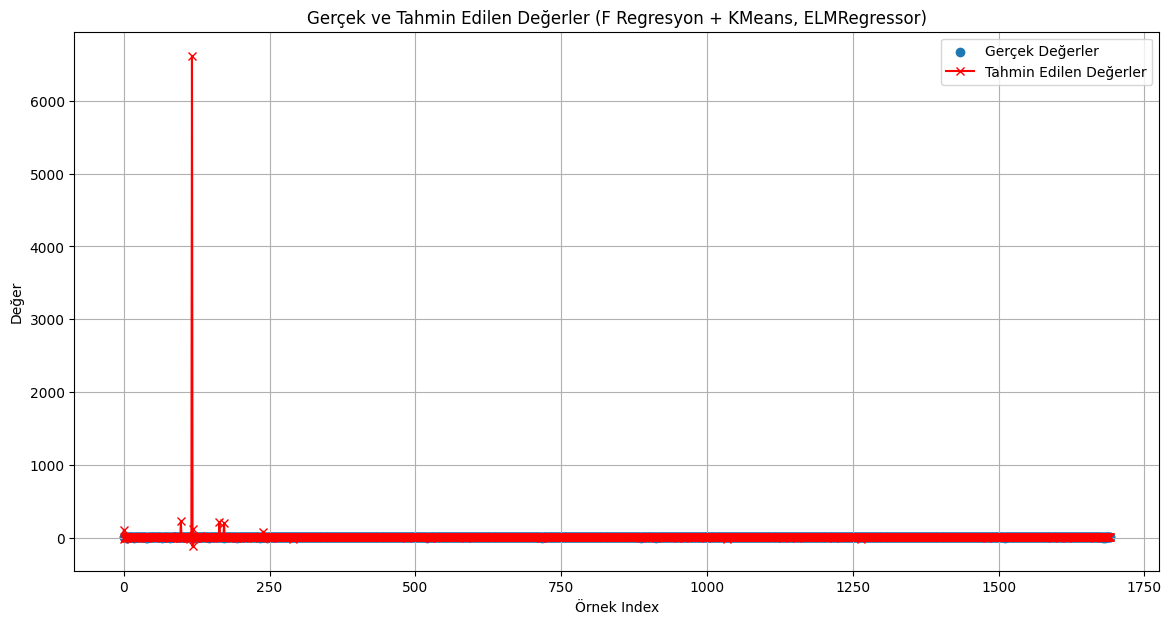

In [58]:

plt.figure(figsize=(14,7))
plt.scatter(np.arange(len(y)), y, label="Gerçek Değerler", marker="o")
plt.plot(np.arange(len(y)), all_predictions.sort_index(), label="Tahmin Edilen Değerler", marker="x", color="red", linestyle="-")
plt.xlabel("Örnek Index")
plt.ylabel("Değer")
plt.title("Gerçek ve Tahmin Edilen Değerler (F Regresyon + KMeans, ELMRegressor)")
plt.legend()
plt.grid(True)
plt.show()
